In [14]:
# Import library
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [15]:
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
from google.colab import files

In [16]:
# Connect with google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Specify the folder path for dataset directory
train_dir = '/content/drive/My Drive/ML_Capstone/Dataset/copra_classified/train'
valid_dir = '/content/drive/My Drive/ML_Capstone/Dataset/copra_classified/valid'
test_dir = '/content/drive/My Drive/ML_Capstone/Dataset/copra_classified/test'

In [18]:
# Count images in each directory
def count_image(directory):
  count = sum(len(files) for _, _, files in os.walk(directory))
  return count

train_count = count_image(train_dir)
valid_count = count_image(valid_dir)
test_count = count_image(test_dir)

print("Number of training data:", train_count)
print("Number of validation data:", valid_count)
print("Number of testing data:", test_count)

Number of training data: 1102
Number of validation data: 314
Number of testing data: 159


In [19]:
# Display the list of files (labels) in each directory
print("Files in training directory:", os.listdir(train_dir))
print("Files in validation directory:", os.listdir(valid_dir))
print("Files in testing directory:", os.listdir(test_dir))

Files in training directory: ['Grade_C', 'Grade_A', 'Grade_B']
Files in validation directory: ['Grade_B', 'Grade_C', 'Grade_A']
Files in testing directory: ['Grade_B', 'Grade_A', 'Grade_C']


In [20]:
# Class to handle iterating over batches of data from an image dataset
class ImageSequence(Sequence):
    def __init__(self, dataset):
        self.dataset = dataset
        self.epoch_end = False

    def __len__(self):
        return self.dataset.samples // self.dataset.batch_size

    def __getitem__(self, i):
        if self.epoch_end:
            self.epoch_end = False
            self.dataset.reset()

        return self.dataset[i]

    def on_epoch_end(self):
        self.epoch_end = True

    def repeat(self):
        self.epoch_end = False
        self.dataset.reset()
        return self

In [21]:
# Augmentation and generator for the training dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=60,
                                   zoom_range=0.3,
                                   fill_mode='nearest')

train_dataset = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical'
)

train_generator = ImageSequence(train_dataset)
train_generator = train_generator.repeat()  # Call the repeat method

Found 1102 images belonging to 3 classes.


In [22]:
# Generator for the validation dataset
validation_dataset = ImageDataGenerator(rescale=1./255).flow_from_directory(valid_dir,
                                                                           target_size=(224, 224),
                                                                           batch_size=16,
                                                                           class_mode='categorical')

validation_generator = ImageSequence(validation_dataset)
validation_generator = validation_generator.repeat()  # Call the repeat method

Found 314 images belonging to 3 classes.


In [23]:
# Function build the classification model
def copra_classification():
    model = keras.Sequential([
      keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224,224,3)),
      keras.layers.MaxPooling2D(2,2),
      keras.layers.Conv2D(128, (3,3), activation='relu'),
      keras.layers.MaxPooling2D(2,2),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy']
    )

    model.summary()

    steps_per_epoch = len(train_generator)
    validation_steps = len(validation_generator)

    history = model.fit(train_generator,
                        epochs=100,
                        validation_data=validation_generator,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps)

    return model, history


In [24]:
if __name__ == '__main__':
    # Call the function to get the model and history
    trained_model, training_history = copra_classification()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 373248)            0         
                                                                 
 dense (Dense)               (None, 128)               4

NameError: ignored

<ipython-input-29-0366215f1239>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(trained_model, "copra_classification_model.h5")


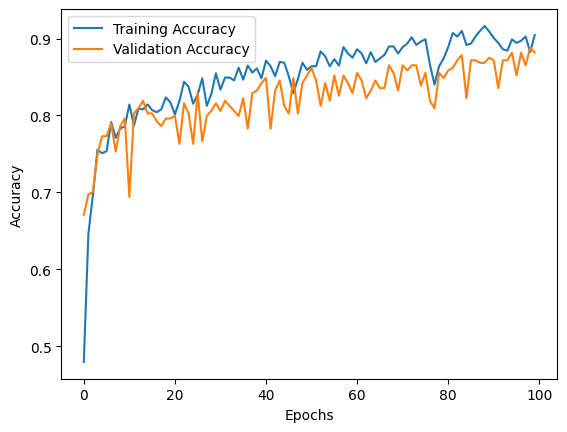

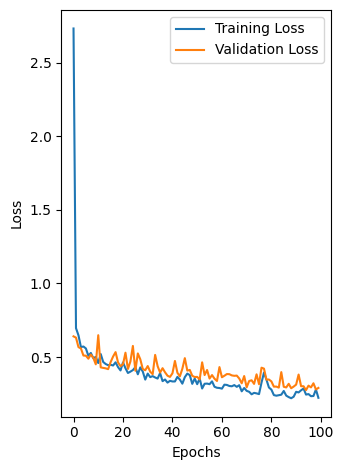

In [29]:
 # Save the model in H5 format
keras.models.save_model(trained_model, "copra_classification_model.h5")

    # Plot the training history
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# evaluate the model with test data
test_dataset = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                                      target_size=(224,224),
                                                                      batch_size=16,
                                                                      class_mode='categorical')

test_generator = ImageSequence(test_dataset)
test_generator = test_generator.repeat() # call the repeat method

test_loss, test_accuracy = trained_model.evaluate(test_generator)
print(f'Test loss: {test_loss: .4f}')
print(f'Test accuracy: {test_accuracy * 100:2f}%')

Found 159 images belonging to 3 classes.
9/9 [==============================] - 49s 6s/step - loss: 0.1470 - accuracy: 0.9375
Test loss:  0.1470
Test accuracy: 93.750000%


Saving CMG_20230418_091414_jpg.rf.7d36e30250e0d01a6311a600edd4b639.jpg to CMG_20230418_091414_jpg.rf.7d36e30250e0d01a6311a600edd4b639.jpg
1/1 [==============================] - 0s 188ms/step
File: CMG_20230418_091414_jpg.rf.7d36e30250e0d01a6311a600edd4b639.jpg
Predicted Class: Grade C
Enter the expected class (Grade A, Grade B, Grade C): Grade C
Prediction is correct!


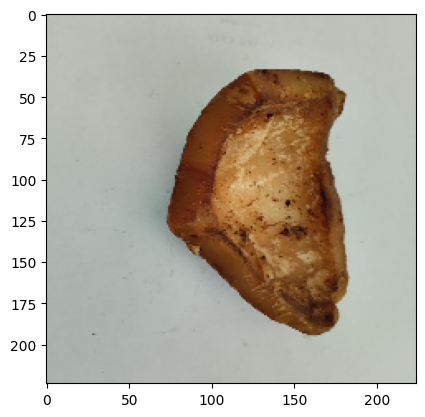

In [34]:
# load image files for prediction
uploaded_file = files.upload()

for file_name in uploaded_file.keys():
    img_path = file_name
    img = image.load_img(img_path, target_size=(224, 224))
    imgplot = plt.imshow(img)

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # make predictions
    classes = trained_model.predict(img_array, batch_size=32)
    predicted_class = np.argmax(classes)

    print("File:", file_name)

    # map numerical class to label
    class_mapping = {0: 'Grade A', 1: 'Grade B', 2: "Grade C"}
    predicted_label = class_mapping[predicted_class]

    print ("Predicted Class:", predicted_label)

    # check if the predicted class matches the expected class
    expected_class = input("Enter the expected class (Grade A, Grade B, Grade C): ").strip()

    if predicted_label == expected_class:
      print('Prediction is correct!')
    else:
      print('Prediction is incorrect. Expected:', expected_class)